In [2]:
import os
from math import ceil

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio
import seaborn as sns
#from scipy.stats import entropy  # Alternatively, you can use scipy.stats.entropy

def calculate_canopy_metric(input_path, output_path, fun, block_size_m=30):
    """
    Calculate a canopy metric in fixed spatial blocks.

    Parameters:
      input_path (str): path to input canopy height model (CHM) raster.
      output_path (str): path where the output raster will be written.
      fun (callable): a function that accepts a 1D numpy array of canopy values and returns a metric.
      block_size_m (float): the size (in meters) of one side of the square block (default is 30).
      
    This function reads the raster, divides it into non‐overlapping blocks (only using full blocks),
    applies the metric function on the valid (non‐nodata) values in each block, and writes the block metric
    as a new raster. Blocks with >50% nodata are assigned a nodata value in the output.
    """
    with rasterio.open(input_path) as src:
        # Read data and convert to float32.
        data = src.read(1).astype(np.float32)
        
        # Handle nodata: replace nodata values with np.nan.
        nodata_val = src.nodata
        if nodata_val is not None:
            nodata_mask = (data == nodata_val)
            data[nodata_mask] = np.nan
        else:
            nodata_mask = np.isnan(data)

        # Compute block size in pixels (assuming square pixels)
        pixel_size = src.res[0]  # resolution in meters (assumed same in x and y)
        block_size = int(block_size_m / pixel_size)
        if block_size < 1:
            raise ValueError("Block size in meters is smaller than the pixel resolution.")

        # Determine new dimensions so that only full blocks are processed
        height, width = data.shape
        new_height = height // block_size
        new_width = width // block_size

        print(f"Input raster size: {height} x {width} pixels")
        print(f"Block size: {block_size} pixels (i.e., {block_size_m} m)")
        print(f"Output raster will be: {new_height} x {new_width} blocks")

        # Trim data and nodata mask to full blocks
        trimmed_data = data[:new_height * block_size, :new_width * block_size]
        trimmed_mask = nodata_mask[:new_height * block_size, :new_width * block_size]

        # Reshape arrays so that each block is accessible as block_data[i, :, j, :]
        block_data = trimmed_data.reshape(new_height, block_size, new_width, block_size)
        block_mask = trimmed_mask.reshape(new_height, block_size, new_width, block_size)

        # Preallocate an output array (we use float32 for the metric values)
        result = np.full((new_height, new_width), np.nan, dtype=np.float32)

        # Loop over blocks and apply the metric function
        for i in range(new_height):
            for j in range(new_width):
                # Calculate the proportion of nodata within the block
                nodata_proportion = np.mean(block_mask[i, :, j, :])
                if nodata_proportion > 0.5:
                    # If >50% of the block is nodata, assign nodata (np.nan)
                    result[i, j] = np.nan
                else:
                    # Extract valid (non-nan) canopy values
                    valid = block_data[i, :, j, :][~np.isnan(block_data[i, :, j, :])]
                    result[i, j] = fun(valid)

        # Compute the new affine transform. We scale the original transform.
        new_transform = src.transform * src.transform.scale(block_size, block_size)
        os.makedirs(os.path.dirname(output_path), exist_ok=True)
        # Write the output raster. (Here we write as float32; you may rescale/round as needed.)
        with rasterio.open(
            output_path,
            'w',
            driver='GTiff',
            height=new_height,
            width=new_width,
            count=1,
            dtype='float32',
            crs=src.crs,
            transform=new_transform,
            nodata=np.nan
        ) as dst:
            dst.write(result, 1)
        print(f"Output written to: {output_path}")


# -----------------------------------
# Define the metric functions
# -----------------------------------

def cover_height_range(min_height, max_height):
    """
    Returns a function that computes the proportion of canopy pixels within a specified height range.
    
    Parameters:
      min_height (float): minimum canopy height.
      max_height (float): maximum canopy height.
      
    The returned function takes a 1D numpy array of canopy values and returns an integer 0-100
    representing the percentage of pixels with values between min_height and max_height.
    """
    def metric(data):
        if data.size == 0:
            return np.nan
        count = np.sum((data >= min_height) & (data <= max_height))
        return int(round((count / data.size) * 100))
    return metric

def median_height(data):
    """
    Returns the median of the canopy heights in the given block.
    """
    if data.size == 0:
        return np.nan
    return np.median(data)

def height_95(data):
    """
    Returns the 95th percentile of canopy heights in the given block.
    """
    if data.size == 0:
        return np.nan
    return np.percentile(data, 95)

def shannon_diversity(data):
    """
    Computes Shannon's entropy of canopy heights after binning into 1.0 m increments.
    
    Shannon's entropy (Shannon 1948) is computed as:
    
        H = -sum(p_i * log(p_i))
    
    where p_i is the proportion of pixels in the i-th bin.
    """
    if data.size == 0:
        return np.nan
    # Define bins: from 0 up to the maximum (ceiled) plus one bin width.
    bins = np.arange(0, np.ceil(np.nanmax(data)) + 1.1, 1.0)  # +1.1 ensures inclusion of the max value
    hist, _ = np.histogram(data, bins=bins)
    total = hist.sum()
    if total == 0:
        return 0.0
    proportions = hist / total
    # Remove zero entries to avoid log(0)
    proportions = proportions[proportions > 0]
    entropy_val = -np.sum(proportions * np.log(proportions))
    return entropy_val

In [5]:
chm_path = 'data/raster/lidar_processed/chms/2019.tif'

# Define metrics and their corresponding subdirectories
metrics = {
    'cover_1-to-2m': cover_height_range(1.0, 2.0),
    'cover_2-to-5m': cover_height_range(2.0, 5.0),
    'cover_5m-plus': cover_height_range(5.0, np.inf),
    'height_median': median_height,
    'height_95th_percentile': height_95,
    'shannon_diversity': shannon_diversity
}

# Loop through metrics and calculate each one
for subdir, metric_func in metrics.items():
    output_path = f'data/raster/lidar_processed/canopy_metrics/{subdir}/2019.tif'
    print(f"Calculating {subdir} metric...")
    calculate_canopy_metric(chm_path, output_path, metric_func)

Calculating cover_1-to-2m metric...
Input raster size: 13281 x 12351 pixels
Block size: 32 pixels (i.e., 30 m)
Output raster will be: 415 x 385 blocks
Output written to: data/raster/lidar_processed/canopy_metrics/cover_1-to-2m/2019.tif
Calculating cover_2-to-5m metric...
Input raster size: 13281 x 12351 pixels
Block size: 32 pixels (i.e., 30 m)
Output raster will be: 415 x 385 blocks
Output written to: data/raster/lidar_processed/canopy_metrics/cover_2-to-5m/2019.tif
Calculating cover_5m-plus metric...
Input raster size: 13281 x 12351 pixels
Block size: 32 pixels (i.e., 30 m)
Output raster will be: 415 x 385 blocks
Output written to: data/raster/lidar_processed/canopy_metrics/cover_5m-plus/2019.tif
Calculating height_median metric...
Input raster size: 13281 x 12351 pixels
Block size: 32 pixels (i.e., 30 m)
Output raster will be: 415 x 385 blocks
Output written to: data/raster/lidar_processed/canopy_metrics/height_median/2019.tif
Calculating height_95th_percentile metric...
Input raste

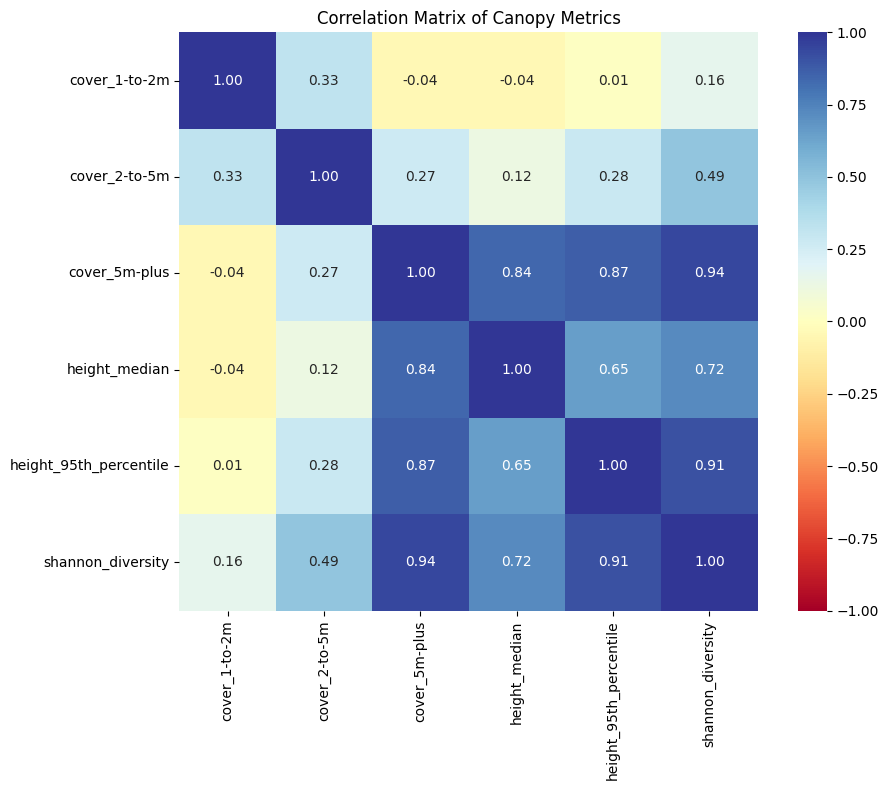

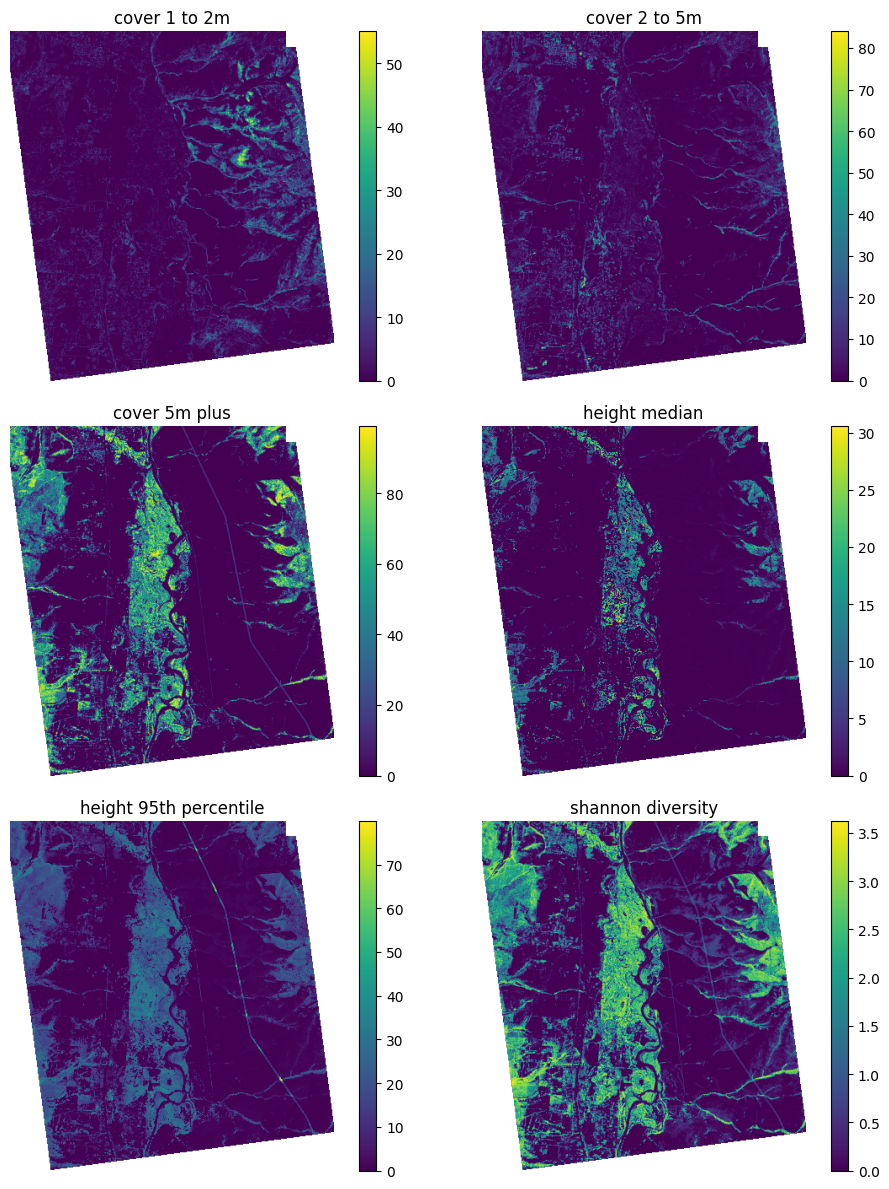

In [6]:
# Read in all metrics and store in a dictionary
metric_data = {}
for metric_name in metrics.keys():
    metric_path = f'data/raster/lidar_processed/canopy_metrics/{metric_name}/2019.tif'
    with rasterio.open(metric_path) as src:
        metric_data[metric_name] = src.read(1).flatten()

# Create a DataFrame from the flattened arrays
df = pd.DataFrame(metric_data)

# Calculate and plot correlation matrix
plt.figure(figsize=(10, 8))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, 
            annot=True, 
            cmap='RdYlBu', 
            vmin=-1, 
            vmax=1, 
            center=0,
            square=True,
            fmt='.2f')
plt.title('Correlation Matrix of Canopy Metrics')
plt.tight_layout()
plt.savefig('results/figures/candidate_metrics_corrmat.png', dpi=300, bbox_inches='tight')

plt.show()

# Create faceted map of metrics
fig, axes = plt.subplots(3, 2, figsize=(10, 12))
axes = axes.flatten()

# Read and plot each metric
for idx, (metric_name, ax) in enumerate(zip(metrics.keys(), axes)):
    metric_path = f'data/raster/lidar_processed/canopy_metrics/{metric_name}/2019.tif'
    with rasterio.open(metric_path) as src:
        data = src.read(1)
        im = ax.imshow(data, cmap='viridis')
        ax.set_title(metric_name.replace('_', ' ').replace('-', ' '))
        ax.axis('off')
        plt.colorbar(im, ax=ax)

plt.tight_layout()
plt.savefig('results/figures/candidate_metrics_maps.png', dpi=300, bbox_inches='tight')

plt.show()



In [3]:
chm_path = 'data/raster/lidar_processed/chms/{YEAR}.tif'

# Define metrics and their corresponding subdirectories
metrics = {
    'cover_1-to-2m': cover_height_range(1.0, 2.0),
    'cover_2-to-5m': cover_height_range(2.0, 5.0),
    'cover_5m-plus': cover_height_range(5.0, np.inf)
}

# Loop through metrics and calculate each one
for yr in [2008, 2009, 2012, 2016, 2019, 2020]:
    for subdir, metric_func in metrics.items():
        input_path = chm_path.format(YEAR=yr)
        output_path = f'data/raster/lidar_processed/canopy_metrics/{subdir}/{yr}.tif'
        print(f"Calculating {subdir} metric...")
        calculate_canopy_metric(input_path, output_path, metric_func)

Calculating cover_1-to-2m metric...
Input raster size: 18209 x 16783 pixels
Block size: 30 pixels (i.e., 30 m)
Output raster will be: 606 x 559 blocks
Output written to: data/raster/lidar_processed/canopy_metrics/cover_1-to-2m/2008.tif
Calculating cover_2-to-5m metric...
Input raster size: 18209 x 16783 pixels
Block size: 30 pixels (i.e., 30 m)
Output raster will be: 606 x 559 blocks
Output written to: data/raster/lidar_processed/canopy_metrics/cover_2-to-5m/2008.tif
Calculating cover_5m-plus metric...
Input raster size: 18209 x 16783 pixels
Block size: 30 pixels (i.e., 30 m)
Output raster will be: 606 x 559 blocks
Output written to: data/raster/lidar_processed/canopy_metrics/cover_5m-plus/2008.tif
Calculating cover_1-to-2m metric...
Input raster size: 14227 x 7009 pixels
Block size: 30 pixels (i.e., 30 m)
Output raster will be: 474 x 233 blocks
Output written to: data/raster/lidar_processed/canopy_metrics/cover_1-to-2m/2009.tif
Calculating cover_2-to-5m metric...
Input raster size: 14